# Heat illnesses during European and World Championships in Athletics

Notebook that visualises the number of various heat-related illnesses against different daily heat indices based on the Universal Thermal Climate Index (UTCI).


Ignore this:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 1. Load the data

In [2]:
# IMPORT PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

path = "/Users/milan/git/AthleticsChampionshipsHeat/data/"

DF = pd.read_excel(path+"IllnessesHeat_10Sep.xlsx")

def ABC2index(S):
    i=0
    for j,s in enumerate(list(S)):
        i += j*26+(ord(s)-65)
    
    return i

In [3]:
# LOAD HEAT ILLNESS DATA
n_heatillness = DF.values[:,ABC2index("O")].astype(np.float)  # number of all heat associated illnesses
n_heatillnsev = DF.values[:,ABC2index("T")].astype(np.float)  # number of severe heat illnesses
n_dehydration = DF.values[:,ABC2index("Y")].astype(np.float)  # number of dehydration
n_others      = DF.values[:,ABC2index("AD")].astype(np.float)  # number of other illnesses

di_heatillness = DF.values[:,ABC2index("AI")].astype(np.float)  # daily incidences of above
di_heatillnsev = DF.values[:,ABC2index("AN")].astype(np.float)
di_dehydration = DF.values[:,ABC2index("AS")].astype(np.float)
di_others      = DF.values[:,ABC2index("AX")].astype(np.float)
di_all         = DF.values[:,ABC2index("N")].astype(np.float) / DF.values[:,ABC2index("E")].astype(np.float) * 1000

ill_long_names = ["Number of all heat associated illnesses",
                    "Number of severe heat illnesses",
                    "Number of dehydration",
                    "Number of other illnesses",
                    "Daily incidences of heat associated illnesses",
                    "Daily incidences of severe heat illnesses",
                    "Daily incidences of dehydration",
                    "Daily incidences of other heat illnesses",
                    "Daily incidences of all illnesses"]

In [4]:
# LOAD UTCI DATA
ndays = len(n_heatillness)
UTCImax = np.zeros((ndays,3))    # time x (expected, min, max)
UTCImaxs = np.zeros((ndays,5,5))
UTCImean = np.zeros((ndays,3))
UTCI3day = np.zeros((ndays,3))
UTCIdiff = np.zeros((ndays,3))

events = ["berlin2009","daegu2011","helsinki2012", "moscow2013","zuerich2014",
          "amsterdam2016","berlin2018"]
events_long = ["Berlin 2009","Daegu 2011","Helsinki 2012","Moscow 2013","Zürich 2014",
        "Amsterdam 2016", "Berlin 2018"]
nevents = len(events)
ndays_per_event = [0,]*nevents

i = 0
for ifile,file in enumerate(events):
    # expected
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff"]
    
    n = len(ma)
    ndays_per_event[ifile] = n
    
    UTCImax[i:i+n,0] = ma
    UTCImean[i:i+n,0] = me
    UTCI3day[i:i+n,0] = td
    UTCIdiff[i:i+n,0] = di
    
    # all
    UTCImaxs[i:i+n,:,:] = np.load(path+file+"utci_daily_maxs.npz")["UTCI_dailymaxs"]
    
    # uncertainty - minimum
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax0"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean0"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean0"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff0"]
    
    UTCImax[i:i+n,1] = ma
    UTCImean[i:i+n,1] = me
    UTCI3day[i:i+n,1] = td
    UTCIdiff[i:i+n,1] = di
    
    # uncertainty - maximum
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax1"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean1"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean1"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff1"]
    
    UTCImax[i:i+n,2] = ma
    UTCImean[i:i+n,2] = me
    UTCI3day[i:i+n,2] = td
    UTCIdiff[i:i+n,2] = di
    
    i += n

nidxs = np.concatenate([[0],np.cumsum(ndays_per_event)])

# sea points are 1e20, mask out
UTCImaxs = np.ma.masked_array(UTCImaxs,mask=UTCImaxs == 1e20)

## 2. Plot all the data

In the following circles denote the respective UTCI-value as close to the stadium as possible. As there is some uncertainty from the climate data as well as in the whereabouts of the athletets, we estimate the uncertainty in the UTCI-values from the range of values within about 25km from the stadium. For Helsinki and Amsterdam, as both stadiums are in the vicinity of water bodies (which can have a large impact on the felt temperature), this yields larger uncertainties than for e.g. Moscow or Berlin. The minimum and maximum of this range is plottet as thin lines.

In [ ]:
# PLOTTING EVERYTHING
colours = ["C0","C1","forestgreen","C3","C4","mediumaquamarine","k"]
ylabels = ["# of illnesses",]*4+["daily incidence",]*5

for i_ill,ill in enumerate([n_heatillness,n_heatillnsev,n_dehydration,n_others,
                            di_heatillness,di_heatillnsev,di_dehydration,di_others,
                            di_all]):

    fig,axs = plt.subplots(2,2,sharey=True,figsize=(10,8))
    alfa=0.7
    lws=1.0

    # scatterpoints for expected
    for i in range(nevents):
        j0,j1 = nidxs[i],nidxs[i+1]
        axs[0,0].scatter(UTCImax[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])
        axs[0,1].scatter(UTCImean[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa)
        axs[1,0].scatter(UTCI3day[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa)
        axs[1,1].scatter(UTCIdiff[j0:j1,0],ill[j0:j1],50,color=colours[i],alpha=alfa)

    # lines for uncertainty
    for i in range(nevents):
        j0,j1 = nidxs[i],nidxs[i+1]
        axs[0,0].plot(UTCImax[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)
        axs[0,1].plot(UTCImean[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)
        axs[1,0].plot(UTCI3day[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)
        axs[1,1].plot(UTCIdiff[j0:j1,1:].T,np.array([ill[j0:j1]]*2),colours[i],lw=lws)

    axs[0,0].set_title("Daily maximum UTCI",loc="left")
    axs[0,1].set_title("Daily mean UTCI",loc="left")
    axs[1,0].set_title("3-day mean UTCI",loc="left")
    axs[1,1].set_title("Daily difference UTCI",loc="left")

    axs[0,0].set_title("a",loc="right",fontweight="bold")
    axs[0,1].set_title("b",loc="right",fontweight="bold")
    axs[1,0].set_title("c",loc="right",fontweight="bold")
    axs[1,1].set_title("d",loc="right",fontweight="bold")

    axs[1,0].set_xlabel("˚C")
    axs[1,1].set_xlabel("˚C")

    axs[0,0].set_ylabel(ylabels[i_ill])
    axs[1,0].set_ylabel(ylabels[i_ill])

    axs[0,0].legend(loc=2,ncol=1,fontsize=9,scatterpoints=3)
    plt.suptitle(ill_long_names[i_ill],x=0,y=1.01,ha="left",fontweight="bold")
    plt.tight_layout()
    
    plt.show()

# 3. Linear/quadratic fit to data

1. Create UTCI bins, e.g. 4 or 5 ˚C
2. Sample randomly from the UTCI distribution for every event day
3. Put the data into the bins from 1.
4. Calculate the e.g. 10% risk of daily incidences
5. Statistically fit the 10% risk of daily incidences to bin-mids via linear/quadratic fit.
6. Repeat 1.-5. N times, as well as for the best-estimate (the central grid point, which is closest to the stadium).
7. Plot the best-estimate fit, as well as the 10-90% range of N fits.

In [5]:
# heat illness risk model, lin/quad with constraint that vertex has to be on x-axis.
def risk_lin(x,a,T0):
    return a*(x-T0)

def risk_quad(x,a,T0):
    return a*(x-T0)**2

# residual functions for least squares estimation
def residual_lin(p,x,y):
    return y-risk_lin(x,*p)

def residual_quad(p,x,y):
    return y-risk_quad(x,*p)

In [6]:
# least squares estimation
prisks = [10,50]                # risk [%] of daily incidence considered
xall = np.linspace(10,40,100)   # evaluate models on these points

# uncertainty
p0 = [0.,15.]
mcn = 1000   # number of monte carlo draws
fits0 = np.empty((len(xall),mcn,len(prisks)))     # heat-related conditions
fits1 = np.empty((len(xall),mcn,len(prisks)))     # heat illnesses
fits2 = np.empty((len(xall),mcn,len(prisks)))     # all illnesses

for ip,prisk in enumerate(prisks):       # loop over different risk levels
    for n in range(mcn):                 # monte carlo mcn times
        UTCIrand = np.empty(ndays)       # pick random UTCI from grid points for each event day
        for ii in range(ndays):
            xy = np.random.randint(0,25)
            while UTCImaxs[ii,:,:].flatten().mask[xy]: # check that we don't pick a masked sea-point
                xy = np.random.randint(0,25)           # if masked, pull another random grid point

            UTCIrand[ii] = UTCImaxs[ii,:,:].flatten().data[xy]

        # pick bins based on sorting the temperatures
        npoints = np.random.randint(5,11)    # reasonable binsizes
        bins = np.sort(UTCIrand)[::npoints]
        bins[-1] = np.max(UTCIrand)          # extend last bin to be inclusive with max
        nbins = len(bins)-1                  # number of bins
        binmids = np.empty(nbins)    # bin centres

        diheatc = np.empty(nbins)     # daily incidence per bin at prisk risk level
        diheati = np.empty(nbins)     # for illnesses too
        diall = np.empty(nbins)       # for all illnesses

        for i in range(nbins):
            which_utcis = np.logical_and(UTCIrand > bins[i],UTCIrand <= bins[i+1])
            ninbins = np.sum(which_utcis)
            
            # incidence rates have a 2std of +-1 error
            diheatc_in_bin = di_heatillness[which_utcis] + 0.5*np.random.randn(ninbins)
            diheati_in_bin = di_heatillnsev[which_utcis] + 0.5*np.random.randn(ninbins)
            diall_in_bin = di_others[which_utcis] + 0.5*np.random.randn(ninbins)
            
            # clip distributions at 0
            diheatc_in_bin = np.maximum(diheatc_in_bin,0)
            diheati_in_bin = np.maximum(diheati_in_bin,0)
            diall_in_bin = np.maximum(diall_in_bin,0)
            
            binmids[i] = np.mean(UTCIrand[which_utcis])
            
            if np.sum(which_utcis) == 0:
                print(prisk,n,i,diheat_in_bin)
            
            diheatc[i] = np.percentile(diheatc_in_bin,100-prisk)
            diheati[i] = np.percentile(diheati_in_bin,100-prisk)
            diall[i] = np.percentile(diall_in_bin,100-prisk)

        # use either linear or quadratic model here
        p0est = optimize.leastsq(residual_lin, p0, args=(binmids, diheatc))[0]       # heat-related conditions
        p1est = optimize.leastsq(residual_lin, p0, args=(binmids, diheati))[0]       # heat illnesses
        p2est = optimize.leastsq(residual_lin, p0, args=(binmids, diall))[0]        # all illnesses
        
        fits0[:,n,ip] = risk_lin(xall,*p0est)
        fits1[:,n,ip] = risk_lin(xall,*p1est)
        fits2[:,n,ip] = risk_lin(xall,*p2est)


/Users/milan/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


In [7]:
pestd = optimize.leastsq(residual_lin, p0, args=(UTCImax[:,0],di_heatillnsev))[0]
fitd = risk_lin(xall,*pestd)

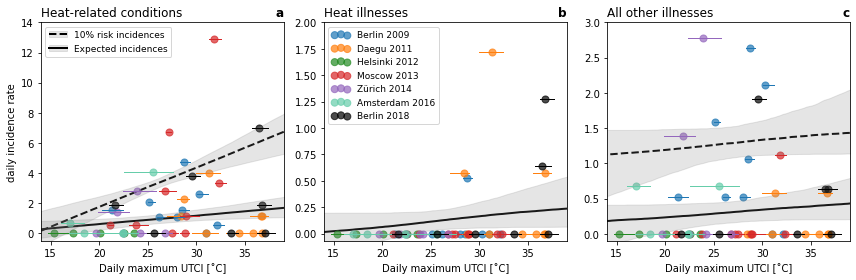

In [19]:
# PLOTTING WHAT's INTERESTING
colours = ["C0","C1","forestgreen","C3","C4","mediumaquamarine","k"]

fig,axs = plt.subplots(1,3,sharex=True,figsize=(12,4))
alfa=0.7
lws=1.0

# scatterpoints for expected
for i in range(nevents):
    j0,j1 = nidxs[i],nidxs[i+1]
    axs[0].scatter(UTCImax[j0:j1,0],di_heatillness[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])
    axs[1].scatter(UTCImax[j0:j1,0],di_heatillnsev[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])
    axs[2].scatter(UTCImax[j0:j1,0],di_others[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])

# lines for uncertainty
for i in range(nevents):
    j0,j1 = nidxs[i],nidxs[i+1]
    axs[0].plot(UTCImax[j0:j1,1:].T,np.array([di_heatillness[j0:j1]]*2),colours[i],lw=lws)
    axs[1].plot(UTCImax[j0:j1,1:].T,np.array([di_heatillnsev[j0:j1]]*2),colours[i],lw=lws)
    axs[2].plot(UTCImax[j0:j1,1:].T,np.array([di_others[j0:j1]]*2),colours[i],lw=lws)


# curve fitting
fb0 = axs[0].fill_between(xall,np.percentile(fits0[:,:,0],5,axis=1),np.percentile(fits0[:,:,0],95,axis=1),color="grey",alpha=0.2)
fb0r2 = axs[0].fill_between(xall,np.percentile(fits0[:,:,1],5,axis=1),np.percentile(fits0[:,:,1],95,axis=1),color="grey",alpha=0.2)
# fb1 = axs[1].fill_between(xall,np.percentile(fits1[:,:,0],5,axis=1),np.percentile(fits1[:,:,0],95,axis=1),color="grey",alpha=0.2)
fb1r2 = axs[1].fill_between(xall,np.percentile(fits1[:,:,1],5,axis=1),np.percentile(fits1[:,:,1],95,axis=1),color="grey",alpha=0.2)
fb2 = axs[2].fill_between(xall,np.percentile(fits2[:,:,0],5,axis=1),np.percentile(fits2[:,:,0],95,axis=1),color="grey",alpha=0.2)
fb2r2 = axs[2].fill_between(xall,np.percentile(fits2[:,:,1],5,axis=1),np.percentile(fits2[:,:,1],95,axis=1),color="grey",alpha=0.2)

h0, = axs[0].plot(xall,np.median(fits0[:,:,0],axis=1),"k--",lw=2,zorder=-5)
h0r2, = axs[0].plot(xall,np.median(fits0[:,:,1],axis=1),"k",lw=2,zorder=-5)
# h1, = axs[1].plot(xall,np.median(fits1[:,:,0],axis=1),"k--",lw=2,zorder=-5)
h1r2, = axs[1].plot(xall,np.median(fits1[:,:,1],axis=1),"k",lw=2,zorder=-5)
h2, = axs[2].plot(xall,np.median(fits2[:,:,0],axis=1),"k--",lw=2,zorder=-5)
h2r2, = axs[2].plot(xall,np.median(fits2[:,:,1],axis=1),"k",lw=2,zorder=-5)

# axs[1].plot(xall,fitd,"C2--")

axs[0].legend([(fb0,h0),(fb0r2,h0r2)],(str(prisks[0])+"% risk incidences","Expected incidences"),loc=2,fontsize=9)

axs[0].set_title("Heat-related conditions",loc="left")
axs[1].set_title("Heat illnesses",loc="left")
axs[2].set_title("All other illnesses",loc="left")

axs[0].set_title("a",loc="right",fontweight="bold")
axs[1].set_title("b",loc="right",fontweight="bold")
axs[2].set_title("c",loc="right",fontweight="bold")

axs[0].set_xlabel("Daily maximum UTCI [˚C]")
axs[1].set_xlabel("Daily maximum UTCI [˚C]")
axs[2].set_xlabel("Daily maximum UTCI [˚C]")

axs[0].set_ylabel("daily incidence rate")

axs[1].legend(loc=2,ncol=1,fontsize=9,scatterpoints=3)

axs[0].set_xlim(14,39)
axs[0].set_ylim(-0.5,14)
axs[1].set_ylim(-0.07,2)
axs[2].set_ylim(-0.1,3)
plt.tight_layout()

plt.show()

In [18]:
np.sum(di_others > 0)

17